### Generate Fake Image using DCGAN

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint

#### Load the data and resize the images

In [2]:
from PIL import Image
all_image_path=[]
full_image_train_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba'

for path in os.listdir(full_image_train_path):
    if '.jpg' in path:
        all_image_path.append(os.path.join(full_image_train_path, path))
    
image_path_10k = all_image_path[0:10000]

print(len(image_path_10k))

10000


In [3]:
crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in image_path_10k]

for i in range(len(images)):
     images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    # images[i] = images[i]*2-1  # if activation is tanh for generator last layer 
    
images = np.array(images) 

In [4]:
# imgs = (imgs-127.5)/127.5
X_train=images

In [5]:
X_train.shape

(10000, 64, 64, 3)

In [6]:
X_train[0]

array([[[0.09019608, 0.05098039, 0.05490196],
        [0.12941176, 0.08235294, 0.08235294],
        [0.14509804, 0.09803922, 0.09803922],
        ...,
        [0.87058824, 0.89411765, 0.94117647],
        [0.87058824, 0.89411765, 0.94117647],
        [0.87058824, 0.89411765, 0.94117647]],

       [[0.08235294, 0.04705882, 0.05098039],
        [0.08627451, 0.04313725, 0.04313725],
        [0.10588235, 0.05882353, 0.05882353],
        ...,
        [0.87058824, 0.89411765, 0.94117647],
        [0.87058824, 0.89411765, 0.94117647],
        [0.87058824, 0.89411765, 0.94117647]],

       [[0.11372549, 0.07843137, 0.08627451],
        [0.10588235, 0.05882353, 0.0627451 ],
        [0.11372549, 0.06666667, 0.06666667],
        ...,
        [0.87058824, 0.89411765, 0.94117647],
        [0.87058824, 0.89411765, 0.94117647],
        [0.87058824, 0.89411765, 0.94117647]],

       ...,

       [[0.74901961, 0.76470588, 0.83921569],
        [0.77254902, 0.77254902, 0.83137255],
        [0.67843137, 0

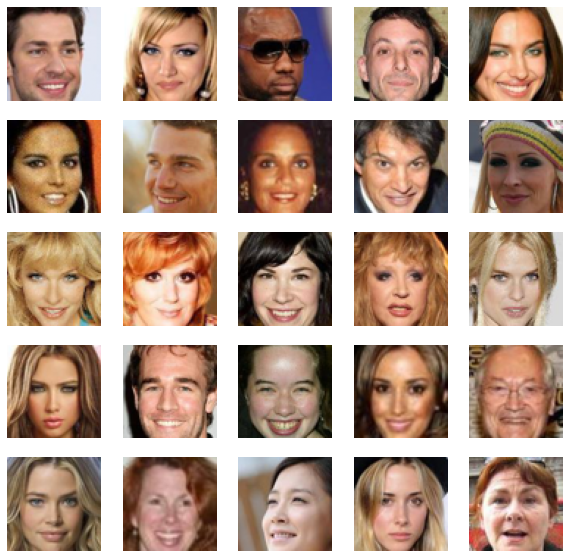

In [7]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()

**Create the discriminator**

In [8]:
def make_discriminator_model():
    model = tensorflow.keras.Sequential()
    model.add(tensorflow.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(tensorflow.keras.layers.LeakyReLU())
    model.add(tensorflow.keras.layers.Dropout(0.3))

    model.add(tensorflow.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tensorflow.keras.layers.LeakyReLU())
    model.add(tensorflow.keras.layers.Dropout(0.3))

    model.add(tensorflow.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tensorflow.keras.layers.LeakyReLU())
    model.add(tensorflow.keras.layers.Dropout(0.3))

    model.add(tensorflow.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tensorflow.keras.layers.LeakyReLU())
    model.add(tensorflow.keras.layers.Dropout(0.3))
    
    model.add(tensorflow.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(tensorflow.keras.layers.LeakyReLU())
    model.add(tensorflow.keras.layers.Dropout(0.3))


    model.add(tensorflow.keras.layers.Flatten())
    model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [9]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         2

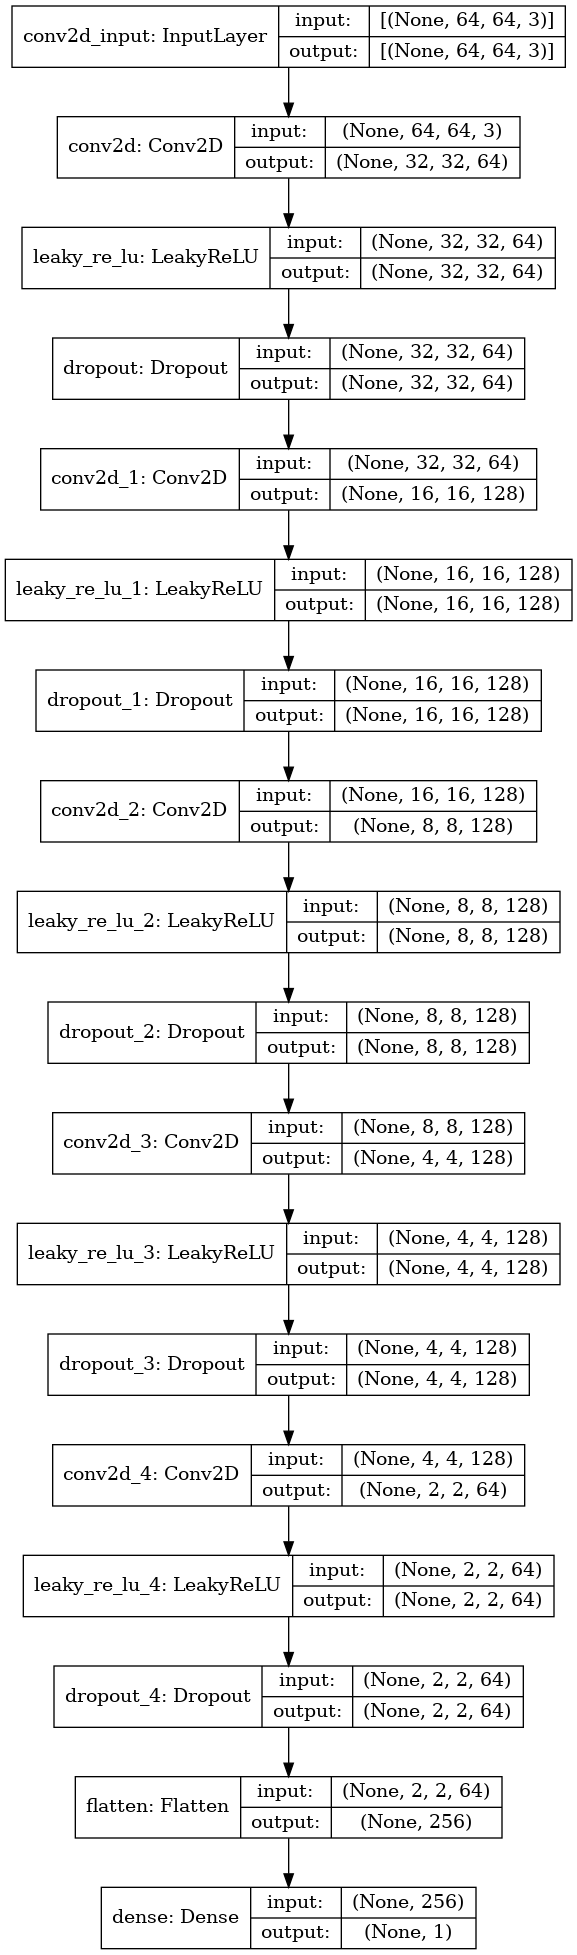

In [10]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
Image(model_to_dot(discriminator, show_shapes=True).create_png(),width=500,height=500)

#### **Create the generator**

In [11]:
def make_generator_model():
    model = tensorflow.keras.Sequential()
    model.add(tensorflow.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tensorflow.keras.layers.Reshape((8, 8, 256)))
    model.add(tensorflow.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')) 
    model.add(tensorflow.keras.layers.BatchNormalization())
    model.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tensorflow.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(tensorflow.keras.layers.BatchNormalization())
    model.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tensorflow.keras.layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same'))
    model.add(tensorflow.keras.layers.BatchNormalization())
    model.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tensorflow.keras.layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation="sigmoid")) # channel=3, activation=tanh

    return model

In [12]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)       

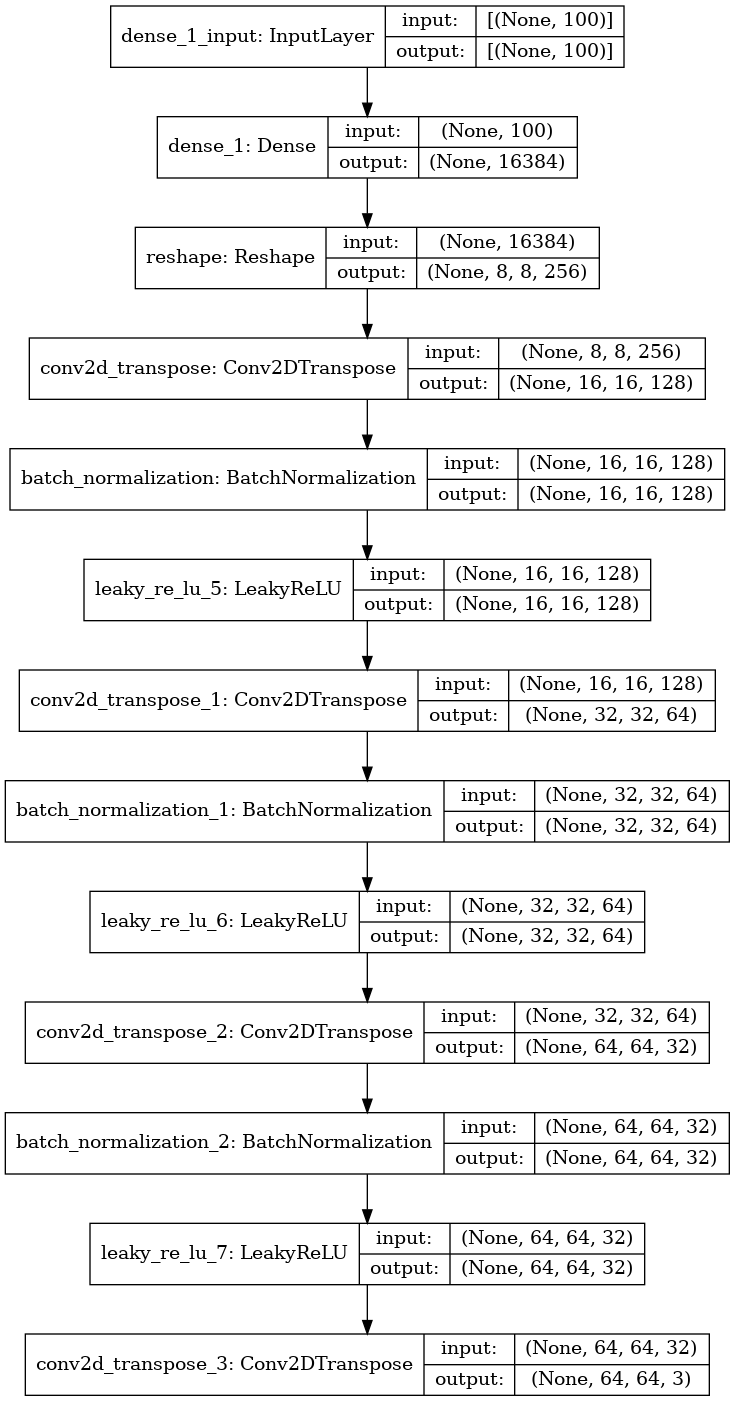

In [13]:
Image(model_to_dot(generator, show_shapes=True).create_png(),width=500,height=500)

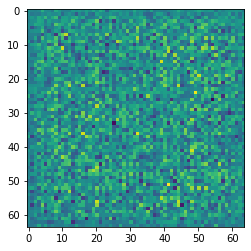

In [14]:
noise = tensorflow.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0]) # generated image

### DCGAN - Combining Generator and Discriminator

Why would we want to do this?

Creating a combined generator and discriminator models, allowing the output images from the generator to flow into discriminator directly, and in turn, allow the error signals from the predicted probabilities of the discriminator to flow back through the weights of the generator model.

**Setting discriminator.trainable to False** will only affect the copy of the discriminator in the combined model. 

In [15]:
# define a composite gan model for the generator and discriminator.

# add generator & discriminator
GAN =tensorflow.keras.Sequential([generator,discriminator])

discriminator.compile(optimizer='adam',loss='binary_crossentropy')

# make weights in the discriminator not trainable
discriminator.trainable = False

# compile model
GAN.compile(optimizer='adam',loss='binary_crossentropy')

GAN.layers

GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         2329187   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 790273    
Total params: 3,119,460
Trainable params: 2,328,739
Non-trainable params: 790,721
_________________________________________________________________


In [16]:
epochs = 50  #set epoch according to your training dataset size.
batch_size = 64
noise_shape = 100

In [17]:
D_loss=[] #list to collect loss for the discriminator model
G_loss=[] #list to collect loss for generator model

Currently on Epoch 1
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


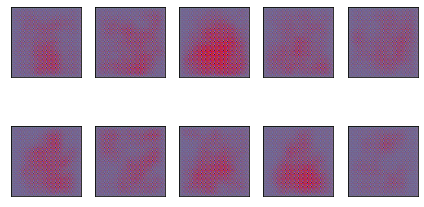

Epoch: 1,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently on Epoch 2
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 2,  Loss: D_real = 0.000, D_fake = 0.000,  G = 0.000
Currently on Epoch 3
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 3,  Loss: D_real = 0.256, D_fake = 0.073,  G = 3.962
Currently on Epoch 4
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 4,  Loss: D_real = 0.606, D_fake = 0.100,  G = 15.502
Currently on Epoch 5
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 5,  Loss: D_real = 0.155, D_fake = 0.190,  G = 3.555
Currently on Epoch 6
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


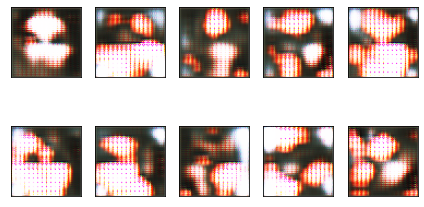

Epoch: 6,  Loss: D_real = 0.062, D_fake = 0.047,  G = 6.478
Currently on Epoch 7
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 7,  Loss: D_real = 0.552, D_fake = 0.195,  G = 2.208
Currently on Epoch 8
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 8,  Loss: D_real = 0.255, D_fake = 0.080,  G = 2.982
Currently on Epoch 9
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 9,  Loss: D_real = 0.025, D_fake = 0.013,  G = 0.114
Currently on Epoch 10
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 10,  Loss: D_real = 0.055, D_fake = 0.039,  G = 1.620
Currently on Epoch 11
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


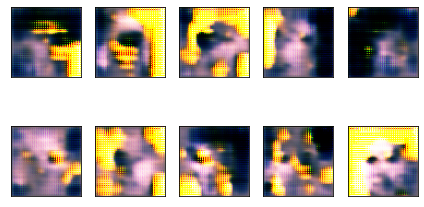

Epoch: 11,  Loss: D_real = 0.027, D_fake = 0.007,  G = 7.612
Currently on Epoch 12
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 12,  Loss: D_real = 0.086, D_fake = 0.195,  G = 3.943
Currently on Epoch 13
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 13,  Loss: D_real = 0.022, D_fake = 0.061,  G = 7.070
Currently on Epoch 14
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 14,  Loss: D_real = 0.073, D_fake = 0.099,  G = 3.512
Currently on Epoch 15
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 15,  Loss: D_real = 0.499, D_fake = 0.179,  G = 5.565
Currently on Epoch 16
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


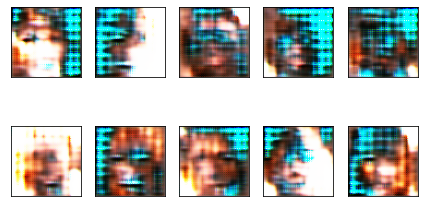

Epoch: 16,  Loss: D_real = 0.207, D_fake = 0.097,  G = 6.768
Currently on Epoch 17
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 17,  Loss: D_real = 0.175, D_fake = 0.135,  G = 6.840
Currently on Epoch 18
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 18,  Loss: D_real = 0.142, D_fake = 0.036,  G = 4.773
Currently on Epoch 19
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 19,  Loss: D_real = 0.167, D_fake = 0.099,  G = 3.329
Currently on Epoch 20
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 20,  Loss: D_real = 0.003, D_fake = 0.025,  G = 6.939
Currently on Epoch 21
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


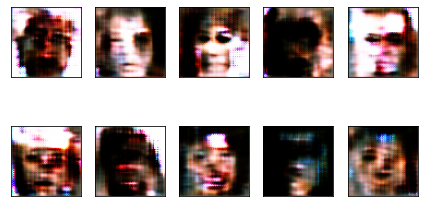

Epoch: 21,  Loss: D_real = 0.057, D_fake = 0.401,  G = 4.755
Currently on Epoch 22
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 22,  Loss: D_real = 0.083, D_fake = 0.138,  G = 6.171
Currently on Epoch 23
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 23,  Loss: D_real = 0.198, D_fake = 0.176,  G = 6.787
Currently on Epoch 24
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 24,  Loss: D_real = 0.029, D_fake = 0.043,  G = 6.346
Currently on Epoch 25
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 25,  Loss: D_real = 0.137, D_fake = 0.119,  G = 5.002
Currently on Epoch 26
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


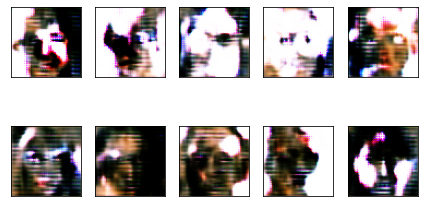

Epoch: 26,  Loss: D_real = 0.071, D_fake = 0.043,  G = 3.176
Currently on Epoch 27
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 27,  Loss: D_real = 0.380, D_fake = 0.006,  G = 7.289
Currently on Epoch 28
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 28,  Loss: D_real = 0.004, D_fake = 0.284,  G = 12.961
Currently on Epoch 29
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 29,  Loss: D_real = 0.037, D_fake = 0.182,  G = 3.687
Currently on Epoch 30
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 30,  Loss: D_real = 0.153, D_fake = 0.136,  G = 4.538
Currently on Epoch 31
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


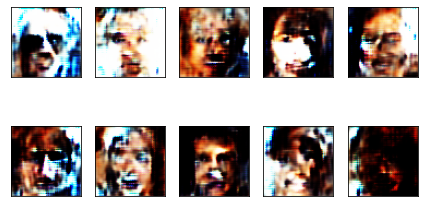

Epoch: 31,  Loss: D_real = 0.193, D_fake = 0.226,  G = 2.618
Currently on Epoch 32
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 32,  Loss: D_real = 0.040, D_fake = 0.130,  G = 5.270
Currently on Epoch 33
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 33,  Loss: D_real = 0.094, D_fake = 0.085,  G = 3.126
Currently on Epoch 34
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 34,  Loss: D_real = 0.128, D_fake = 0.049,  G = 3.532
Currently on Epoch 35
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 35,  Loss: D_real = 0.366, D_fake = 0.070,  G = 5.262
Currently on Epoch 36
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


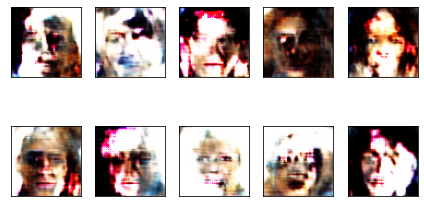

Epoch: 36,  Loss: D_real = 0.302, D_fake = 0.219,  G = 4.180
Currently on Epoch 37
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 37,  Loss: D_real = 0.034, D_fake = 0.266,  G = 5.486
Currently on Epoch 38
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 38,  Loss: D_real = 0.263, D_fake = 0.094,  G = 3.756
Currently on Epoch 39
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 39,  Loss: D_real = 0.135, D_fake = 0.179,  G = 4.374
Currently on Epoch 40
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 40,  Loss: D_real = 0.056, D_fake = 0.102,  G = 3.221
Currently on Epoch 41
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


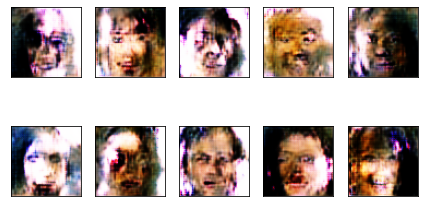

Epoch: 41,  Loss: D_real = 0.270, D_fake = 0.134,  G = 3.746
Currently on Epoch 42
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 42,  Loss: D_real = 0.400, D_fake = 0.278,  G = 3.639
Currently on Epoch 43
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 43,  Loss: D_real = 0.278, D_fake = 0.023,  G = 5.724
Currently on Epoch 44
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 44,  Loss: D_real = 0.003, D_fake = 0.028,  G = 6.505
Currently on Epoch 45
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 45,  Loss: D_real = 0.054, D_fake = 0.055,  G = 5.182
Currently on Epoch 46
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156


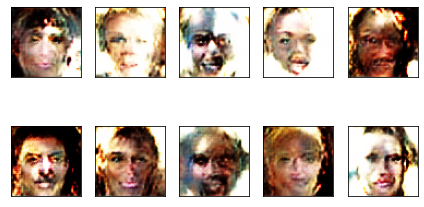

Epoch: 46,  Loss: D_real = 0.056, D_fake = 0.284,  G = 4.557
Currently on Epoch 47
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 47,  Loss: D_real = 0.417, D_fake = 0.067,  G = 4.814
Currently on Epoch 48
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 48,  Loss: D_real = 0.052, D_fake = 0.049,  G = 5.715
Currently on Epoch 49
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 49,  Loss: D_real = 0.063, D_fake = 0.056,  G = 4.801
Currently on Epoch 50
	 Currently on batch number 0 of 156
	 Currently on batch number 100 of 156
Epoch: 50,  Loss: D_real = 0.097, D_fake = 0.288,  G = 4.431
Training is complete


In [18]:
with tensorflow.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size): 
        
        if (i)%100 == 0:
            print(f"\t Currently on batch number {i} of {len(X_train)//batch_size}") # first calculate the number of batches per epoch = dataset_size / batch_size

# update the discriminator model 

        # generate points in the latent space
        # reshape into a batch of inputs for the network
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape]) 
        
        # generate fake images.
        gen_image = generator.predict_on_batch(noise)
        
        # select a batch of real images
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        
        #train on real image
        train_label=np.ones(shape=(batch_size,1)) # define target labels for real images
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label) # update the discriminator for real images
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1)) # define target labels for fake images
        d_loss2 = discriminator.train_on_batch(gen_image,train_label) # update the discriminator for fake images
        
# update the generator model   
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)
        
         
    if epoch % 5 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])

        
        plt.tight_layout()
        plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('Training is complete')

                                                                                                                Dhanya Jayan